In [313]:
%matplotlib inline

import numpy as np
import random
import pandas as pd
import requests as rq
import sys
import io
import os
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from collections import Counter
from datetime import datetime
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [314]:
# # code to run the dataset 
# YEARS = range(2010,2012)
# data = pd.DataFrame()
# for YEAR in YEARS:  
#     print(str(YEAR))
#     i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
#                    'play_by_play_' + str(YEAR) + '.csv.gz',
#                    compression= 'gzip', low_memory= False)
#     data = pd.concat([data, i_data], sort=True)



Data Cleaning

In [315]:
##get data
##data is already from 2012-2020
data = pd.read_csv('cleaneddata.csv') # pandas data frame


#Variable Time Stamping
# Currently, each play is treated as a single timestep. If possible, 
# consider using multiple timesteps per sample to include more historical context.
# For instance, using the last n plays within the same drive as a sequence might help the model understand the context better and improve predictions.

##preprocessing

##filter to only patriots
#data = data.loc[(data['home_team'] == 'NE') | (data['away_team'] == 'NE')]

##removes 
data = data.loc[(data['desc'].str.startswith('('))]
data = data[data['play_type'] != 'qb_kneel']
data = data[data['play_type'] != 'no_play']
data = data[data['posteam'] == 'NE']
data = data.dropna(subset=['down'])
data = data.dropna(subset=['play_type'])
data = data.dropna(subset=['wp'])
data = data[(data['play_type'] == 'pass') | (data['play_type'] == 'run') | (data['play_type'] == 'punt') | (data['play_type'] == 'field_goal')]

# Extract year and month using string slicing
data['year'] = data['game_id'].str[:4].astype(int)
data['month'] = data['game_id'].str[5:7].astype(int)
# Create a new 'date' column with the 1st day of each extracted year and month


# Come back to this when we want to specify split spots  
# def parse_date(x):
#     parts = x.split('_')
#     year = int(parts[0])predictions = model.predict(X_test)

# Apply the function to the 'game_date' column
# data['date'] = data['game_id'].apply(parse_date)
# # Now you can sort by this 'date' column if needed
# data.sort_values(by='date', inplace=True)

# # And use the 'date' column for splitting your data, work with in the future to pick specific dates 
# #Right now not working because the months in the game_id are 01-12, when for pd.TimeStamp they need to be in 1-12. 
# split_date = pd.Timestamp(year=2018, month=12, day=1)  # Replace YYYY and MM with your split year and month
# train_data = data[data['date'] < split_date]
# test_data = data[data['date'] >= split_date]

 
##fixes playtype to be strictly pass or run 
##lables scrambles as passes
data.loc[data['pass']==1,'play_type'] = 'pass'
data.loc[data.rush==1,'play_type'] = 'run'

# columns are the strings 
# things to encode from strings to 1s and zeros
# season_type, 
columnsKeep = ['game_id', 'year','month','season_type','week','posteam','posteam_type','defteam','side_of_field','yardline_100','half_seconds_remaining','home_team','away_team',
               'game_seconds_remaining','game_half','drive','down','time','yrdln','ydstogo','desc','play_type','yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel',
               'qb_spike','qb_scramble','pass_length','run_location','run_gap','home_timeouts_remaining','away_timeouts_remaining','total_home_score','total_away_score',
               'passer_player_name','receiver_player_name','rusher_player_name','play_type_nfl','roof','surface','temp','wind','home_coach','away_coach','game_stadium',
               'success', 'wp']



data = data[columnsKeep]

# print(data.head(5))

data.to_csv('finalized_data.csv', index=False)

/tmp/ipykernel_7447/1793728709.py:3: DtypeWarning: Columns (45,179,180,189,190,197,198,203,204,205,206,218,219,220,222,224,226,253,254,255,260,262,263,283,284,294,295,301) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaneddata.csv') # pandas data frame


In [316]:
print(len(data))

# Count occurrences of each play type
runCount = (data['play_type'] == 'run').sum()
passCount = (data['play_type'] == 'pass').sum()

print("Number of 'run' plays:", runCount)
print("Number of 'pass' plays:", passCount)

10489
Number of 'run' plays: 3942
Number of 'pass' plays: 5624


In [317]:
##check for nan values in data
for index, row in data.iterrows():
    if pd.isnull(row['play_type']):  # Check if the value in the 'down' column is NaN
        print(row['desc'])  # Print the value in the 'desc' column if 'down' is NaN

# wind and stadium had a lot of null 
## check for missing values in data
selected_features = ['down', 'drive', 'ydstogo', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining','wp', 'play_type']
missing_values_features = data[selected_features].isnull().sum()
print("Missing values in selected features:")
print(missing_values_features)

# Check for missing values in the target
missing_values_target = data['play_type'].isnull().sum()
print("\nMissing values in target (play_type):", missing_values_target)


Missing values in selected features:
down                      0
drive                     0
ydstogo                   0
yardline_100              0
half_seconds_remaining    0
game_seconds_remaining    0
wp                        0
play_type                 0
dtype: int64

Missing values in target (play_type): 0


In [318]:
data

,game_id,year,month,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,...,play_type_nfl,roof,surface,temp,wind,home_coach,away_coach,game_stadium,success,wp
16,2012_01_NE_TEN,2012,1,REG,1,NE,away,TEN,NE,74.0,...,PASS,outdoors,grass,74.0,4.0,Mike Munchak,Bill Belichick,LP Field,1.0,0.407754
17,2012_01_NE_TEN,2012,1,REG,1,NE,away,TEN,NE,66.0,...,RUSH,outdoors,grass,74.0,4.0,Mike Munchak,Bill Belichick,LP Field,0.0,0.428245
18,2012_01_NE_TEN,2012,1,REG,1,NE,away,TEN,NE,65.0,...,RUSH,outdoors,grass,74.0,4.0,Mike Munchak,Bill Belichick,LP Field,1.0,0.407163
19,2012_01_NE_TEN,2012,1,REG,1,NE,away,TEN,TEN,48.0,...,PASS,outdoors,grass,74.0,4.0,Mike Munchak,Bill Belichick,LP Field,0.0,0.479147
20,2012_01_NE_TEN,2012,1,REG,1,NE,away,TEN,TEN,48.0,...,RUSH,outdoors,grass,74.0,4.0,Mike Munchak,Bill Belichick,LP Field,0.0,0.462335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26066,2020_17_NYJ_NE,2020,17,REG,17,NE,home,NYJ,NE,58.0,...,RUSH,outdoors,grass,33.0,5.0,Bill Belichick,Adam Gase,Gillette Stadium,1.0,0.997668
26068,2020_17_NYJ_NE,2020,17,REG,17,NE,home,NYJ,NYJ,49.0,...,RUSH,outdoors,grass,33.0,5.0,Bill Belichick,Adam Gase,Gillette Stadium,0.0,0.998655
26069,2020_17_NYJ_NE,2020,17,REG,17,NE,home,NYJ,NYJ,48.0,...,RUSH,outdoors,grass,33.0,5.0,Bill Belichick,Adam Gase,Gillette Stadium,0.0,0.998544
26070,2020_17_NYJ_NE,2020,17,REG,17,NE,home,NYJ,NYJ,46.0,...,RUSH,outdoors,grass,33.0,5.0,Bill Belichick,Adam Gase,Gillette Stadium,0.0,0.999085


In [319]:
data.columns

Index(['game_id', 'year', 'month', 'season_type', 'week', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
       'half_seconds_remaining', 'home_team', 'away_team',
       'game_seconds_remaining', 'game_half', 'drive', 'down', 'time', 'yrdln',
       'ydstogo', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle',
       'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length',
       'run_location', 'run_gap', 'home_timeouts_remaining',
       'away_timeouts_remaining', 'total_home_score', 'total_away_score',
       'passer_player_name', 'receiver_player_name', 'rusher_player_name',
       'play_type_nfl', 'roof', 'surface', 'temp', 'wind', 'home_coach',
       'away_coach', 'game_stadium', 'success', 'wp'],
      dtype='object')

In [320]:
data['play_type']

16       pass
17        run
18        run
19       pass
20        run
         ... 
26066     run
26068     run
26069     run
26070     run
26072    punt
Name: play_type, Length: 10489, dtype: object

In [321]:
encode_cols = [
    'season_type', 'posteam', 'posteam_type', 'defteam', 'side_of_field',
    'home_team', 'away_team', 'time', 'desc', 'pass_length', 'run_location',
    'run_gap'
]

In [322]:
def is_not_number(val):
    return not isinstance(val, (int, float, complex))

In [323]:
# for column in columnsKeep:
#     print(data[column].iloc[0])

In [324]:
feats = ['play_type_nfl', 'rusher_player_name', 'receiver_player_name', 'passer_player_name',
         'run_gap', 'run_location', 'pass_length', 'qb_scramble', 'qb_dropback', 'shotgun',
         'down', 'play_type']
data = data[feats]

In [325]:
data

,play_type_nfl,rusher_player_name,receiver_player_name,passer_player_name,run_gap,run_location,pass_length,qb_scramble,qb_dropback,shotgun,down,play_type
16,PASS,NaN,A.Hernandez,T.Brady,NaN,NaN,short,0,1.0,0,1.0,pass
17,RUSH,S.Ridley,NaN,NaN,guard,left,NaN,0,0.0,0,2.0,run
18,RUSH,S.Ridley,NaN,NaN,tackle,left,NaN,0,0.0,0,3.0,run
19,PASS,NaN,B.Lloyd,T.Brady,NaN,NaN,deep,0,1.0,0,1.0,pass
20,RUSH,S.Ridley,NaN,NaN,NaN,middle,NaN,0,0.0,0,2.0,run
...,...,...,...,...,...,...,...,...,...,...,...,...
26066,RUSH,S.Michel,NaN,NaN,NaN,middle,NaN,0,0.0,0,2.0,run
26068,RUSH,C.Newton,NaN,NaN,NaN,middle,NaN,0,0.0,0,1.0,run
26069,RUSH,C.Newton,NaN,NaN,NaN,middle,NaN,0,0.0,1,2.0,run
26070,RUSH,C.Newton,NaN,NaN,guard,right,NaN,0,0.0,1,3.0,run


,play_type_nfl,rusher_player_name,receiver_player_name,passer_player_name,run_gap,run_location,pass_length,qb_scramble,qb_dropback,shotgun,down,play_type


In [311]:
# Label encode categorical features

from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical


#features = columnsKeep
target = to_categorical(data['play_type'].map({'pass': 0, 'run': 1, 'field_goal': 2, 'punt': 3}))# Initialize the scaler 

le = LabelEncoder()

#data['play_type'] = le.fit_transform(data['play_type'])


label_encoders = {}
for column in feats:
    if is_not_number(data[column].iloc[0]) | None:
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le  
        
# data['rusher_player_name'] = le.fit_transform(data['rusher_player_name'])
# data['run_gap'] = le.fit_transform(data['run_gap'])
# data['run_location'] = le.fit_transform(data['run_location'])

ValueError: zero-size array to reduction operation maximum which has no identity

In [277]:
# Check if there are NaN values after mapping
print(data['play_type'].map({'pass': 0, 'run': 1, 'field_goal': 2, 'punt': 3}).isna().sum())


10489


In [295]:
data

,play_type_nfl,rusher_player_name,receiver_player_name,passer_player_name,run_gap,run_location,pass_length,qb_scramble,qb_dropback,shotgun,down,play_type
16,1,NaN,4,10,NaN,NaN,1,0,1.0,0,1.0,1
17,3,S.Ridley,85,11,guard,left,2,0,0.0,0,2.0,3
18,3,S.Ridley,85,11,tackle,left,2,0,0.0,0,3.0,3
19,1,NaN,8,10,NaN,NaN,0,0,1.0,0,1.0,1
20,3,S.Ridley,85,11,NaN,middle,2,0,0.0,0,2.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
26066,3,S.Michel,85,11,NaN,middle,2,0,0.0,0,2.0,3
26068,3,C.Newton,85,11,NaN,middle,2,0,0.0,0,1.0,3
26069,3,C.Newton,85,11,NaN,middle,2,0,0.0,1,2.0,3
26070,3,C.Newton,85,11,guard,right,2,0,0.0,1,3.0,3


In [279]:
data.dtypes

play_type_nfl             int64
rusher_player_name       object
receiver_player_name      int64
passer_player_name        int64
run_gap                  object
run_location             object
pass_length               int64
qb_scramble               int64
qb_dropback             float64
shotgun                   int64
down                    float64
play_type                 int64
dtype: object

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical



scaler = StandardScaler() 


# Fit the scaler on the features and transform them 
features_scaled = scaler.fit_transform(data)

# Reshaping input data for LSTM [samples, time steps, features]
# Here, we assume each sample is a single time step
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Talk to Nicolai and Ulrich if they think this is a good idea to split it up into drives as our time stamp. 
# 1 indicates that each sample consists of 1 timestep. This is a key detail: 
# it means you are treating each play as a separate, single-timestep sequence. T
# This is a simplification, as ideally, plays within a single drive might be treated as sequences to capture their temporal dependencies.

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle = False)

#Initalize model
model = Sequential()

# input_shape corresponds to (time steps, features)
model.add(LSTM(units=64, return_sequences=True, input_shape=(1, features_scaled.shape[2])))
model.add(Dropout(0.2))  # Adding dropout to avoid overfitting

# Adding a second LSTM layer
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
# Since binary classification (pass/run), we use 1 unit with a sigmoid activation function
model.add(Dense(units=4, activation='sigmoid'))

# compilinh the model,
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

#Training the model using the training data, 
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}')



#Accuracy
#Definition: This is the metric that measures the performance of your model on the entire training dataset. In simpler terms, it represents the percentage of correct predictions that the model makes when it is fed the training data.
#Purpose: Accuracy on the training set helps you understand how well the model is learning the intended patterns from the data it is trained on. It provides a direct measure of the model's effectiveness in fitting the data.

# Validation Accuracy (val_accuracy)
# Definition: This is the metric that measures the performance of your model on a separate validation dataset that is not used for the training of the model. 
# The validation set is a subset of the data that is held back from the training process and is used specifically to assess model performance during training.
# Purpose: Validation accuracy is critical because it gives an early indicator of how well the model is likely to perform on unseen data, helping to diagnose issues such as overfitting. 
# Overfitting occurs when a model learns patterns specific to the training data, but these patterns do not generalize to new data

ValueError: could not convert string to float: 'S.Ridley'

In [241]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_test_classes, predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, predicted_classes))



2024-04-24 13:38:59.482580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-24 13:38:59.484387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-24 13:38:59.485744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      1083
           1       0.00      0.00      0.00       829
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       130

    accuracy                           0.52      2098
   macro avg       0.13      0.25      0.17      2098
weighted avg       0.27      0.52      0.35      2098

Confusion Matrix:
[[1083    0    0    0]
 [ 829    0    0    0]
 [  56    0    0    0]
 [ 130    0    0    0]]


/home/mhowed/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mhowed/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mhowed/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


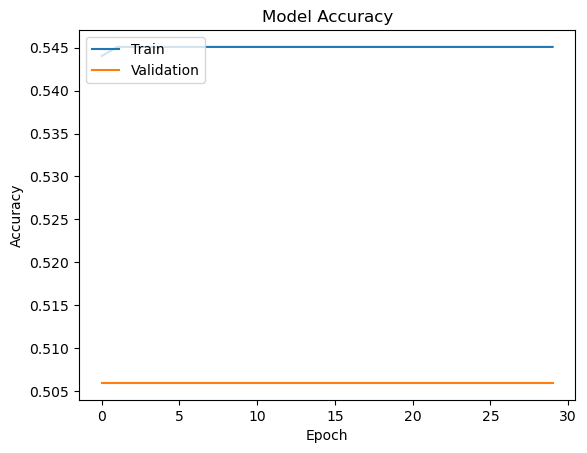

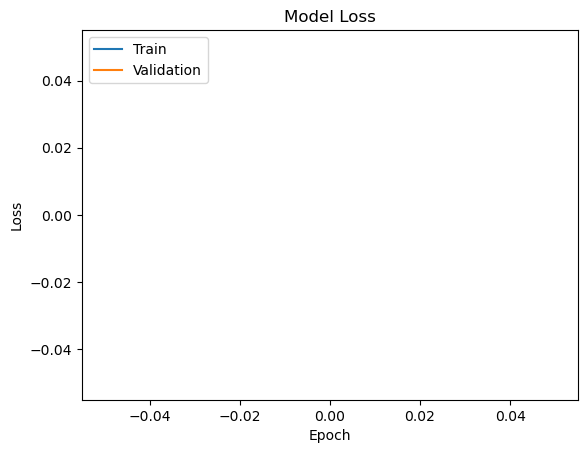

In [242]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [243]:
#
# focus more on data tarnsformations 

In [244]:
# length of X train, and nulls in the x,train, x_test, y_train, y_test 
print(len(X_train))
nan_indices_X = np.isnan(X_train)
nan_count_X = np.sum(nan_indices_X)
print(nan_count_X)

nan_indices_X_test = np.isnan(X_test)
nan_count_X_test = np.sum(nan_indices_X_test)
print(nan_count_X_test)

nan_indices_y = np.isnan(y_train)
nan_count_y = np.sum(nan_indices_y)
print(nan_count_y)

nan_indices_Y_test = np.isnan(y_test)
nan_count_Y_test = np.sum(nan_indices_Y_test)
print(nan_count_Y_test)

print("Shape of X_train:", X_train.shape)

8391
1218
576
0
0
Shape of X_train: (8391, 1, 49)


In [245]:
data.dtypes

game_id                      int64
year                         int64
month                        int64
season_type                  int64
week                         int64
posteam                      int64
posteam_type                 int64
defteam                      int64
side_of_field                int64
yardline_100               float64
half_seconds_remaining     float64
home_team                    int64
away_team                    int64
game_seconds_remaining     float64
game_half                    int64
drive                      float64
down                       float64
time                         int64
yrdln                        int64
ydstogo                      int64
desc                         int64
play_type                    int64
yards_gained               float64
shotgun                      int64
no_huddle                    int64
qb_dropback                float64
qb_kneel                     int64
qb_spike                     int64
qb_scramble         

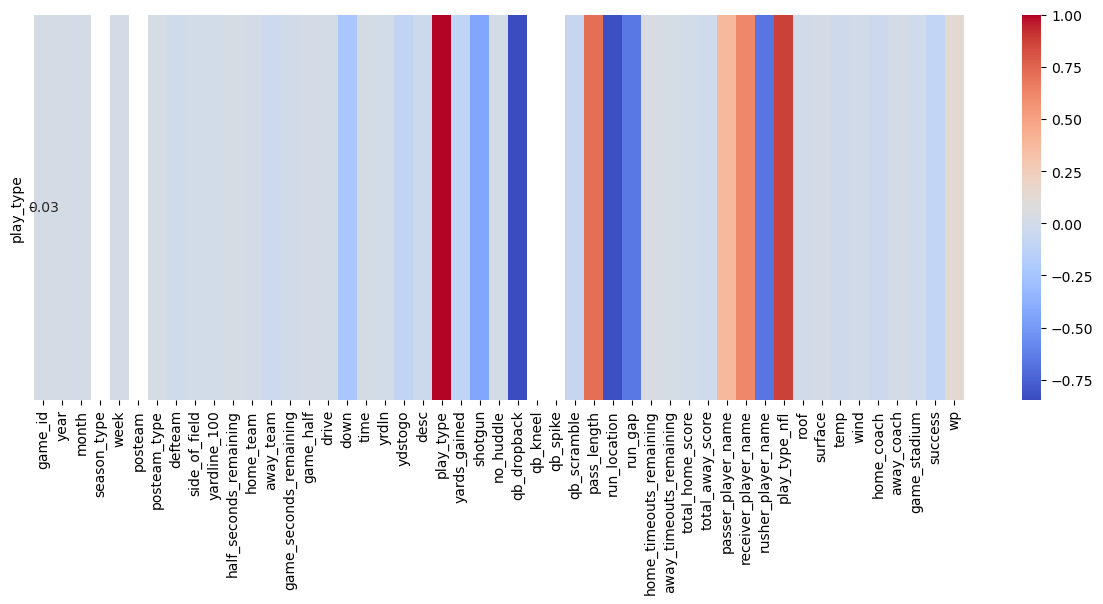

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

corr_matrix = data.corr()

feature_corr = corr_matrix[['play_type']].transpose()


sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.show()